In [2]:
"""
Basic Neural Net to recognize people in the LFW data set from torchvision. 
"""

import torch
from torch import nn
from torchvision import datasets 
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from PIL import Image


In [3]:
torch.cuda.is_available()

True

In [4]:
train_data = datasets.LFWPeople(
    root = "train_data",
    split =  "train",
    download = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.LFWPeople(
    root = "test_data",
    split =  "test",
    download = True,
    transform = ToTensor(),

)

100%|██████████| 243346528/243346528 [03:13<00:00, 1255282.39it/s]


Extracting train_data\lfw-py\lfw-funneled.tgz to train_data\lfw-py


100%|██████████| 66403/66403 [00:00<00:00, 319098.97it/s]


100%|██████████| 94727/94727 [00:00<00:00, 450590.79it/s]


100%|██████████| 243346528/243346528 [03:14<00:00, 1252826.22it/s]


Extracting test_data\lfw-py\lfw-funneled.tgz to test_data\lfw-py


100%|██████████| 28334/28334 [00:00<00:00, 497465.02it/s]


100%|██████████| 94727/94727 [00:00<00:00, 453645.23it/s]


In [5]:
test_data

Dataset LFWPeople
    Number of datapoints: 3708
    Root location: test_data\lfw-py
    Alignment: funneled
    Split: test
    Classes (identities): 5749
    StandardTransform
Transform: ToTensor()

In [6]:
converter = ToTensor()
def load_data(type):
    dataset_path = f"{type}_data\\lfw-py\\lfw_funneled"
    labels = []
    for subdir, dir, files in os.walk(dataset_path):
        labels += dir
    #print(labels)
    images = []
    final_labels = []
    for label in labels:
        files =  os.listdir(dataset_path + os.sep +label)
        for file in files:
            image = Image.open(dataset_path + os.sep +label + os.sep + file)
            images.append(converter(image))
            final_labels.append(label)
    
    return images, final_labels 

test_data, test_labels = load_data( type = "test")
train_data, train_labels = load_data(type = "train")

In [7]:
class_names = list(set(train_labels))
len(class_names), class_names

(5749,
 ['Gordana_Grubin',
  'Mohamed_Seineldin',
  'Paul_Gascoigne',
  'Thomas_Bjorn',
  'Brian_Billick',
  'Matt_Anderson',
  'Orrin_Hatch',
  'Chen_Liang_Yu',
  'Janine_Pietsch',
  'Suk_Chung_Hong',
  'Melvin_Talbert',
  'Juliette_Lewis',
  'Rod_Blagojevich',
  'James_Comey',
  'Mohammed_Salmane',
  'Farouk_Kaddoumi',
  'Barrett_Jackman',
  'Jerry_Bruckheimer',
  'Steve_Shiver',
  'Goran_Zivkovic',
  'Abdullah',
  'Maurice_Papon',
  'Festus_Mogae',
  'Dominic_Monaghan',
  'Joseph_LePore',
  'Francis_George',
  'Diane_Lane',
  'Luke_Smith',
  'Momir_Nikolic',
  'Doug_Duncan',
  'Roman_Coppola',
  'Recep_Tayyip_Erdogan',
  'Kyle_Shewfelt',
  'Ronald_Perelman',
  'Hugh_Campbell',
  'Gideon_Yago',
  'Donald_Keck',
  'Eurico_Guterres',
  'Frank_Marshall',
  'Hiroki_Gomi',
  'Michael_Boyce',
  'Bob_Crippen',
  'Nate_Huffman',
  'Gennifer_Flowers',
  'Mahmoud_Abbas',
  'Michael_Fitzgerald',
  'James_Becker',
  'Hussein_Malik',
  'Tom_Amstutz',
  'Jerry_Rice',
  'John_Norquist',
  'Daryl_Jo

In [8]:
def clean_labels(labels):
    return [ class_names.index(label) for label in labels]

cleaned_train_labels = clean_labels(train_labels)
cleaned_test_labels = clean_labels(test_labels)


In [9]:
final_train_data = list(zip(train_data, cleaned_train_labels))
final_test_data = list(zip(test_data, cleaned_test_labels))
final_train_data[0][0].shape

torch.Size([3, 250, 250])

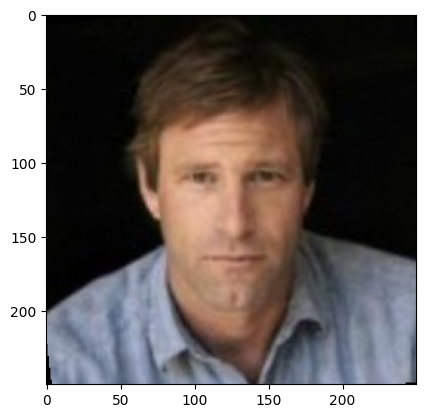

In [10]:
plt.imshow(train_data[0].permute(1, 2, 0))

In [11]:
from torch.utils.data import DataLoader
batch_size = 32
train_dataloader = DataLoader(final_train_data ,
                              batch_size = batch_size,
                              shuffle = True)
test_dataloader = DataLoader(final_test_data ,
                             batch_size = batch_size,
                             shuffle = False )

In [12]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 250, 250]), torch.Size([32]))

In [13]:
class PeopleModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 9 , 
                      stride = 1, 
                      padding = 1),

            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 9 , 
                      stride = 1, 
                      padding = 1),
            nn.ReLU(),          
            nn.MaxPool2d(kernel_size =2 , 
                         stride = 2)

        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 9, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 9, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size =2 , 
                         stride = 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 56180, # height * width
                      out_features = output_shape)
        )
    def forward(self, x):
        return self.classifier(self.block_2(self.layer_stack(x)))

In [14]:
epochs = 100
device = "cuda"
def train_model(model, optimizer, loss_fn):
    model = model.to(device)
    test_losses = train_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch, (x,y) in enumerate(train_dataloader):
            x, y = x.to(device), y.to(device)
            
            y_logits = model(x)
            loss_batch = loss_fn( y_logits, y)
            train_loss += loss_batch
            optimizer.zero_grad()
            loss_batch.backward()
            optimizer.step()
            
        train_loss /= len(train_dataloader)

        if epoch % 10 == 0:
            model.eval()
            with torch.inference_mode():

                test_loss = 0
                for batch, (x,y) in enumerate(test_dataloader):
                    x, y = x.to(device), y.to(device)
                    y_test = model(x)
                    loss_batch_test = loss_fn( y_test, y)
                    test_loss += loss_batch_test
                test_loss /= len(test_dataloader)
            
            test_losses.append(test_loss)
            train_losses.append(train_loss)

            print(f"Train Loss {train_loss}, Test Loss {test_loss}")
    return model, train_losses, test_losses


In [15]:

model = PeopleModel(input_shape = 3,
                    hidden_units = 20,
                    output_shape= len(class_names))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters())


In [16]:
model, train_losses, test_losses = train_model(model, optimizer, loss_fn)


Train Loss 8.443463325500488, Test Loss 7.929134368896484
Train Loss 0.6579262614250183, Test Loss 0.4959736764431
Train Loss 0.003226077649742365, Test Loss 0.000682369340211153
Train Loss 5.7435896451352164e-05, Test Loss 5.440017412183806e-05
Train Loss 3.27408779412508e-05, Test Loss 3.1801770091988146e-05
Train Loss 2.3035265257931314e-05, Test Loss 2.254874380014371e-05
Train Loss 1.7765270968084224e-05, Test Loss 1.7479080270277336e-05
Train Loss 1.4475016541837249e-05, Test Loss 1.4268478480516933e-05
Train Loss 1.2194487680972088e-05, Test Loss 1.2054402759531513e-05
Train Loss 1.053152845997829e-05, Test Loss 1.0427457709738519e-05


In [17]:
len(train_losses[0:10]), train_losses[0:2]

(10,
 [tensor(7.9291, device='cuda:0'),
  tensor(8.4435, device='cuda:0', grad_fn=<DivBackward0>)])

In [18]:
final_train_losses = [ loss.cpu().detach().numpy()  for idx, loss in enumerate(train_losses) if idx % 2 == 1  ]
final_test_losses = [ loss.cpu().detach().numpy()  for idx, loss in enumerate(test_losses) if idx % 2 == 0  ]

In [19]:
epoch_list = [ i for i in range(10,110, 10)]
epoch_list

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [25]:
len(test_losses), test_losses[0:2]

(20,
 [tensor(7.9291, device='cuda:0'),
  tensor(8.4435, device='cuda:0', grad_fn=<DivBackward0>)])

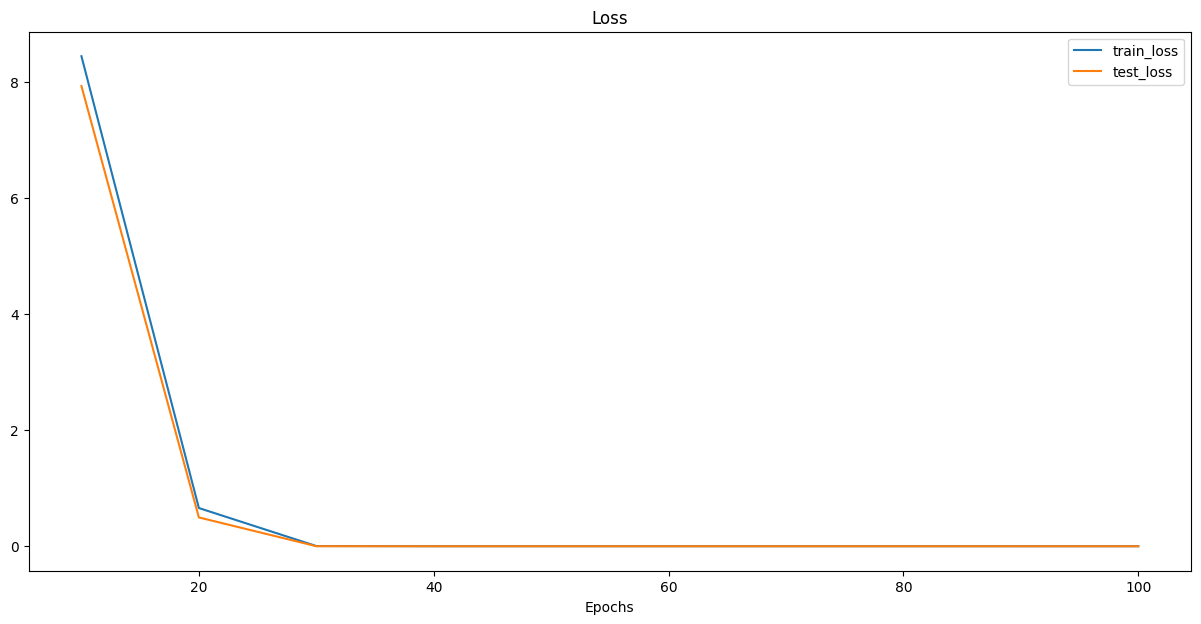

In [21]:
plt.figure(figsize=(15, 7))

# Plot loss
plt.plot(epoch_list, final_train_losses, label='train_loss')
plt.plot(epoch_list, final_test_losses, label='test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()


In [22]:
print(final_train_data[0][0].shape, final_train_data[0][0].unsqueeze(0).shape, final_train_data[0][1])


torch.Size([3, 250, 250]) torch.Size([1, 3, 250, 250]) 943


In [23]:
# Making a prediciton using the model

with torch.inference_mode():
    y_pred = model(final_test_data[0][0].unsqueeze(0).to("cuda"))

print(y_pred.shape, y_pred)
prediction_index = torch.softmax(y_pred,dim = 1).argmax()
print(f"Prediction as index: {prediction_index},  Prediction as Name: {class_names[int(prediction_index)]}  \nActual Index {final_train_data[0][1]} as index {class_names[final_train_data[0][1]]}")

torch.Size([1, 5749]) tensor([[ 4.0796,  1.9102, -4.8989,  ...,  0.9176,  4.2044,  4.5935]],
       device='cuda:0')
Prediction as index: 943,  Prediction as Name: Aaron_Eckhart  
Actual Index 943 as index Aaron_Eckhart


In [28]:
torch.manual_seed(42)

def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def eval_model(model, data_loader, loss_fn, accuracy_fn, device):
    loss, acc = 0.0, 0.0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)            
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

results = eval_model(model=model, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device)

print(results)

{'model_name': 'PeopleModel', 'model_loss': 9.294113624491729e-06, 'model_acc': 100.0}
